# Advancing Pneumonia Diagnosis Through Neural Networks
***
**Author:** Ron Lodetti Jr.
![doctor](./images/doctor_crop.jpg)

Image by <a href="https://www.freepik.com/free-photo/doctor-checking-radiography-front-view_35436186.htm#fromView=search&page=1&position=0&uuid=0c377c4a-a764-4319-8c20-d708851a4835">Freepik</a>

## Overview
***
In this project, I developed a machine learning model to enhance the diagnosis of pneumonia in pediatric patients using 5,863 high-quality, expert-diagnosed chest X-ray images from the Guangzhou Women and Children’s Medical Center. Data preparation involved reorganizing the dataset into an 80-10-10 split for training, validation, and test sets, maintaining consistent positive/negative ratios. Images were downsampled during import to balance computational efficiency with image quality, cropped to a uniform aspect ratio of 1.37 to prioritize central content, and rescaled for normalization, ensuring reliable model training and evaluation.

Utilizing TensorFlow and Keras, my modeling process involved iterative training and evaluation, focusing on optimizing loss, recall, and AUC metrics for accurate pneumonia detection. I began with simpler models, progressively incorporating more complex configurations, including Conv2D layers and increased nodes. To prevent overfitting, I experimented with dropout layers, L1/L2 regularization, and data augmentation. I also tested various initializers and optimizers to enhance model efficiency. Furthermore, I applied transfer learning with the pretrained ResNet50 model to improve results.

The final model demonstrated an exceptional ability to identify pneumonia, achieving a recall of 97.2% and an AUC of 99.11% on unseen test data. These results highlight its potential for accurately diagnosing pneumonia and suggest strong generalizability to new data. This project underscores the significant promise of machine learning in improving pediatric pneumonia diagnosis, offering a pathway towards more efficient and accurate healthcare solutions.

## Business Problem
***
Pneumonia, a significant respiratory condition that affects millions globally, presents a diagnostic challenge as much time and resources are spent manually interpreting chest x-rays by radiologists. 

I have been tasked by a children's hospital to develop a model that can classify whether a given patient has pneumonia, given a chest x-ray image. If successful, this could significantly improve diagnosis accuracy and efficiency, ultimately providing better care for patients.

In [1]:
# Standard library imports
import os
import random
from pathlib import Path

# Data handling
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
from skimage.color import gray2rgb, rgb2gray
from skimage.segmentation import mark_boundaries

# Data visualization
import matplotlib.pyplot as plt

# Machine Learning, Deep Learning frameworks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Rescaling)
from tensorflow.keras.metrics import AUC, Recall
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE as tf_AUTOTUNE
from tensorflow.random import set_seed as tf_set_seed
from tensorflow import tile as tf_tile

# Lime for model explanation
from lime.lime_image import LimeImageExplainer
from lime.wrappers.scikit_image import SegmentationAlgorithm

# Custom modules
from src import data_modeling, data_prep, data_understanding, evaluation

# Set the random seeds for reproducibility
SEED = 42
tf_set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Set TensorFlow log level to minimize the log output for cleaner notebook execution
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

2024-04-03 13:37:03.157727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Understanding
The dataset originally comes from Kermany et al. on [Mendeley](https://data.mendeley.com/datasets/rscbjbr9sj/3). I downloaded the data from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) as it had already separated out the chest x-ray images from other data in the original dataset.

The following description is taken directly from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia):
>The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).
>
>Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
>
>For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.


Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010.

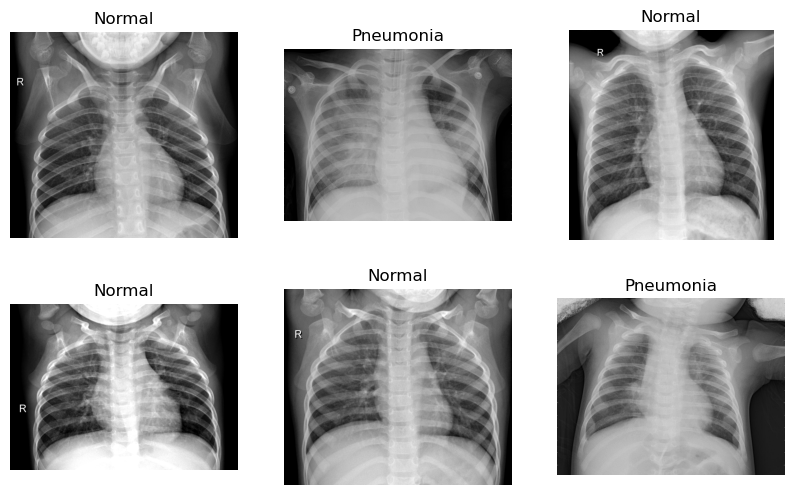

In [2]:
# Displaying 6 random raw images and their labels.

normal_dir = 'data/chest_xray/train/NORMAL/'
pneumonia_dir = 'data/chest_xray/train/PNEUMONIA/'

data_understanding.show_images(normal_dir,pneumonia_dir)

I noticed that the images have different dimensions. During data prep, I'll be sure to standardize the aspect ratio as I don't want my model to make any predictions based on the aspect ratio of the image. 

In [3]:
# Displaying the number of images in each directory.

data_dir = 'data/chest_xray'
folders = ['train', 'val', 'test']
df = data_understanding.prepare_plot(data_dir,folders)
df

,Dataset,Normal,Pneumonia,Total
0,train,1341,3875,5216
1,val,8,8,16
2,test,234,390,624


I notice that there are only 16 total images in the validation set. Also, the ratio of Positive (Pneumonia) to Negative images aren't consistent betwen train, validation, and test datasets. 

## Data Preparation
***
To prepare my data for modeling I:
- Reorganized the image files.
- Imported my training data, standardizing aspect ratio.
- Applied scaling to the training data for normalization.
- Imported validation data to be used test the model's performance.
- Created a specialized dataset specifically formatted for use with the ResNet50 classifier.

### Reorganized the image files.
I redistributed the data, giving an 80-10-10 train-validation-test split. I also made sure to keep the positive/negative ratio the same for each dataset. 

In [4]:
# Run the run_redistribution function from the data_prep module

# Function below is commented out as it is programmed to change the contents 
# of your data directories. Use with caution. 

# data_prep.run_redistribution()

In [5]:
# Displaying the number of images in each new directory.

new_folders = ['new_train', 'new_val', 'new_test']
new_df = data_understanding.prepare_plot(data_dir,new_folders)
new_df

,Dataset,Normal,Pneumonia,Total
0,new_train,1266,3419,4685
1,new_val,158,427,585
2,new_test,159,429,588


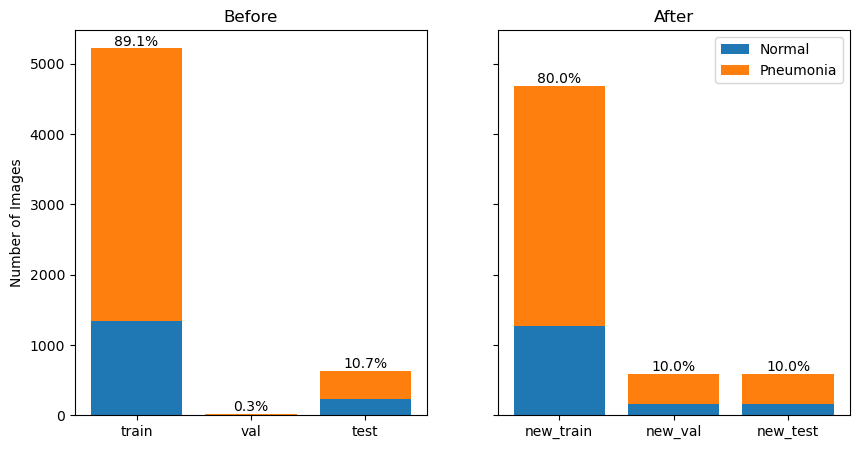

In [6]:
# Displaying the distribution of the datasets before and after redistribution
data_prep.compare_bar(df, new_df)

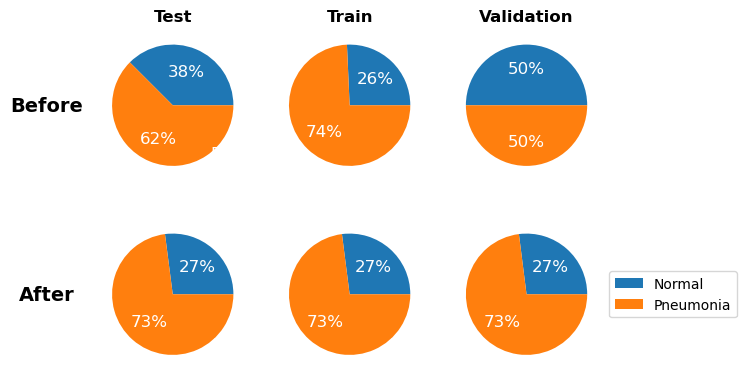

In [7]:
# Displaying the positive/negative ratio for each dataset before and after redistribution
data_prep.pie(df, new_df)

Now that we have an 80-10-10 stratified split, I want to standardize the aspect ratio of the images. 

In [8]:
# Combining the widths and heights of training and validation to analyze image size statistics.
# Note that the test set is not included here to avoid data leakage. 
train_dir = 'data/chest_xray/new_train'
val_dir = 'data/chest_xray/new_val'

# Extract image dimensions from training and validation directories
train_widths, train_heights = data_prep.get_image_sizes(train_dir)
val_widths, val_heights = data_prep.get_image_sizes(val_dir)

# Merge width and height arrays from training and validation sets for comprehensive statistics
widths = np.concatenate((train_widths, val_widths))
heights = np.concatenate((train_heights, val_heights))

# Display image size statistics and store average aspect ratio
AVG_RATIO = data_prep.print_image_statistics(widths, heights) #1.3686277519996741

Number of images: 5270
Average width: 1326
Average height: 969
Average aspect ratio: 1.3686495194791897
Max width: 2916
Max height: 2713
Min width: 384
Min height: 127


###  Create Dataset
Since the average aspect ratio is about 1.37, I'll crop my images to that ratio when importing without distorting the image itself. Given that the important information is likely in the center of the image, cropping edges of the images likely would not impact the classification.

In [9]:
def create_dataset(directory, ratio=AVG_RATIO, process=False, is_training=False):
    """
    Creates a dataset from a directory of images, resizing them to a consistent size.

    Parameters:
    - directory: Path to the directory where the image files are located.
    - ratio: Aspect ratio to determine the width of the images based on a fixed height.
    - process: Whether or not to apply additional data processing.
    - is_training: To differntiate between training, validation, and testing sets.

    Returns:
    A tf.data.Dataset object.
    """
    height = 64 # Size chosen based on processing resources
    width = int(height * ratio) # setting the width to ensure average aspect ratio
    dataset = image_dataset_from_directory(
        directory,
        label_mode='binary', # There are two labels, 'Normal' or 'Pneumonia'
        color_mode="grayscale", # Original images are in grayscale, specifying to ensure dimension reduction
        batch_size=32, # selected  based on processing resources
        image_size=(height, width),
        shuffle=is_training,  # Shuffle only if it's the training dataset
        crop_to_aspect_ratio=True,
        seed=42
    )
    if process:
        return process_dataset(dataset) # Applying any additional processing steps if necessary
    else:
        return dataset

In [10]:
# Creating the dataset without additional processing
preprocessed_train_ds = create_dataset(train_dir, is_training=True)

Found 4685 files belonging to 2 classes.


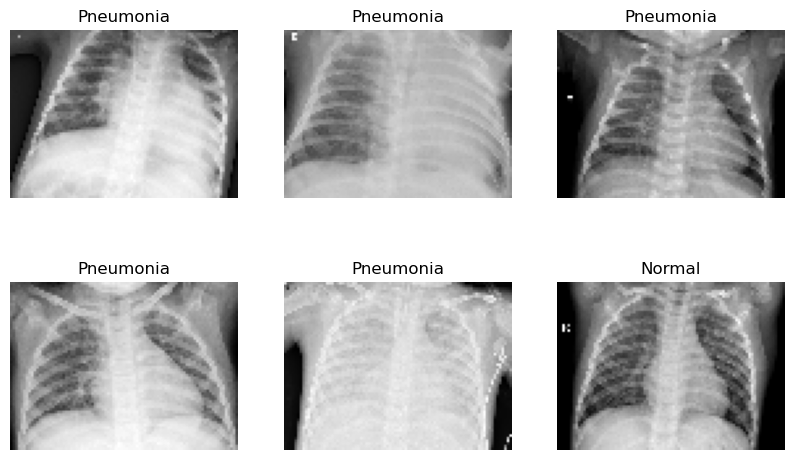

In [11]:
# Displaying images after importing
data_prep.show_images(preprocessed_train_ds)

Images are a consistent aspect ratio and appear to still include imnportant information. They are also noticably grainer, which could affect the future model's prediction abilities. 

In [12]:
# Inspecting an imported image tensor
for inputs, labels in preprocessed_train_ds.take(1):
        image_tensor = inputs[0]
        print(image_tensor)

tf.Tensor(
[[[66.844826  ]
  [79.84914   ]
  [85.93965   ]
  ...
  [75.58623   ]
  [59.823273  ]
  [54.870667  ]]

 [[76.29741   ]
  [86.676735  ]
  [90.81034   ]
  ...
  [87.81886   ]
  [73.90521   ]
  [77.49133   ]]

 [[76.10776   ]
  [86.6293    ]
  [75.28018   ]
  ...
  [91.637924  ]
  [99.89224   ]
  [94.80175   ]]

 ...

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [71.267166  ]
  [52.538788  ]
  [36.491333  ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.10344887]
  ...
  [74.77565   ]
  [54.995667  ]
  [39.53875   ]]

 [[ 0.        ]
  [ 0.        ]
  [ 0.        ]
  ...
  [69.702545  ]
  [53.16809   ]
  [43.137917  ]]], shape=(64, 87, 1), dtype=float32)


Let's rescale the tensor to improved model performance.

In [13]:
from tensorflow.data import AUTOTUNE as tf_AUTOTUNE
def process_dataset(dataset, is_training=False):
    """
    Processes the dataset by rescaling, (optionally shuffling for validation/test), caching, and prefetching.

    Parameters:
    - dataset: A tf.data.Dataset object to process.
    - is_training: To differntiate between training, validation, and testing sets.

    Returns:
    A processed tf.data.Dataset object.
    """
    # Normalizing the dataset by rescaling
    rescale = Rescaling(1./255)
    dataset = dataset.map(lambda x, y: (rescale(x), y), num_parallel_calls=tf_AUTOTUNE)

    if is_training:
        # Shuffle only if it's the training dataset
        dataset = dataset.shuffle(buffer_size=1000, seed=42)

    # Cache the dataset to improve performance
    dataset = dataset.cache()

    # Prefetch to optimize loading
    dataset = dataset.prefetch(tf_AUTOTUNE)

    return dataset

In [14]:
# Processing training dataset
train_ds = process_dataset(preprocessed_train_ds, is_training=True)

# Inspecting a processed image tensor
for inputs, labels in train_ds.take(1):
        image_tensor = inputs[0]
        print(image_tensor)

tf.Tensor(
[[[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.26510158]
  [0.22708328]
  [0.2130427 ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.26675093]
  [0.24050198]
  [0.21394187]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.2741621 ]
  [0.24666178]
  [0.21988346]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]], shape=(64, 87, 1), dtype=float32)


The tensor is scaled. Let's see if this affected the images.

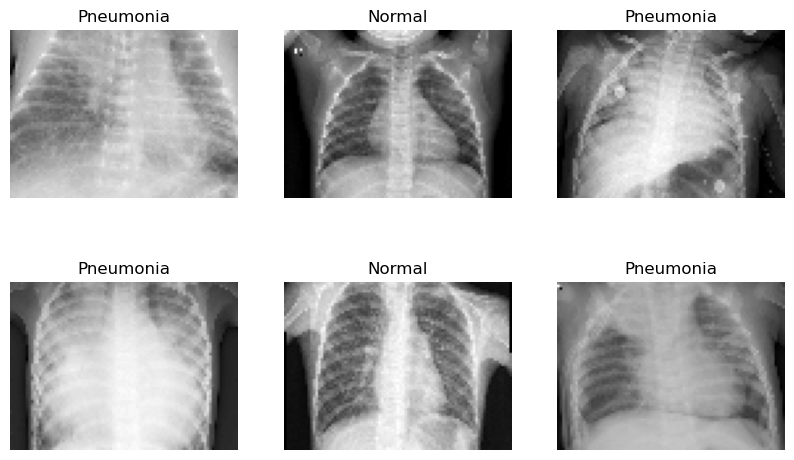

In [15]:
# Displaying processed images and their labels
data_prep.show_images(train_ds)

The images are still the correct aspect ratio and possibly grainier, although scaling should reduce any actual data. 

### Validation dataset
I will be using the validation dataset to score any model trained to see how it does on unseen data.

In [16]:
# Create and process validation set
val_ds = create_dataset(val_dir, ratio=AVG_RATIO, process=True, is_training=False)

# Calculating input shape to be fed into model
for inputs, labels in train_ds.take(1):
        input_shape = inputs.shape[1:]
        break
print(f'Input Shape:{input_shape}')

Found 585 files belonging to 2 classes.
Input Shape:(64, 87, 1)


###  Dataset for ResNet50
For compatibility with the pretrained ResNet50 model, the input data shape must be adjusted. ResNet50 requires inputs to have three channels (RGB color channels), whereas my current data is in grayscale, consisting of only one channel.

In [17]:
# Load and preprocess training dataset
train_ds_grayscale = create_dataset(train_dir, is_training=True)
# Convert training dataset images to RGB
train_ds_rgb = train_ds_grayscale.map(data_prep.convert_to_rgb)
# Further preprocess for ResNet compatibility
train_ds_resnet = process_dataset(train_ds_rgb, is_training=True)

# Repeat process for validation dataset
val_ds_grayscale = create_dataset(val_dir)
val_ds_rgb = val_ds_grayscale.map(data_prep.convert_to_rgb)
val_ds_resnet = process_dataset(val_ds_rgb)

# Determine ResNet input shape from first batch
for inputs, labels in train_ds_resnet.take(1):
    resnet_input_shape = inputs.shape[1:]
    break

# Display determined ResNet input shape
print(f'Resnet Input Shape:{resnet_input_shape}')

Found 4685 files belonging to 2 classes.
Found 585 files belonging to 2 classes.
Resnet Input Shape:(64, 87, 3)


## Data Modeling
***
During the modeling process, I iteratively trained and evaluated numerous models to identify the most effective one. A validation dataset, previously unseen by the model, was used for evaluation to ensure accuracy in real-world scenarios. To inform my decision-making, I relied on both loss and recall metrics, aiming to minimize error while maximizing the model's ability to correctly identify pneumonia cases. I also included the Area Under the ROC Curve (AUC) to provide insight into the model's overall performance, ensuring it doesn't just achieve high recall by simply labeling all cases as positive.

Key adjustments made during model iterations and hyperparameter tuning included:

- Adjusting the number and configuration of layers and nodes.
- Choosing between Dense and Conv2D layers for structure.
- Implementing regularization techniques such as Dropout layers, L1/L2 regularization, and data augmentation to prevent overfitting.
- Selecting appropriate initializers and optimizers for optimization.
- Applying transfer learning with the pretrained ResNet50 model to leverage pre-existing neural network architectures.

In [18]:
METRICS = [
    Recall(name='recall'),
    AUC(name='auc')]

### Baseline Model
For my baseline model I decided to use a simple neural network with no hidden layers. 

,Train Loss,Val Loss,Val Recall,Val AUC
Baseline,0.2517,0.2461,0.9016,0.9565


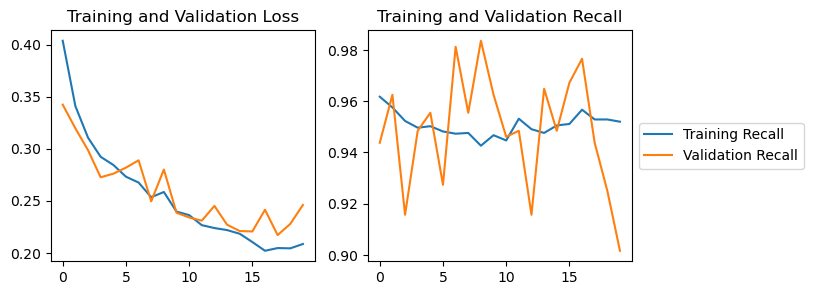

In [19]:
baseline_model = Sequential([
    Flatten(input_shape=input_shape),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')]) # using sigmoid activation and one node in my output layer for binary classification

# Choosing the 'Adam' optimizer for efficiencty.
# Choosing 'binary_crossentropy' as loss function given bineary classification. 
baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# results = model.fit(train_ds, epochs=20, validation_data=val_ds)

baseline_model = data_modeling.summary_viz('Baseline', train_ds, val_ds)

19/19 [==============================] - 0s 3ms/step


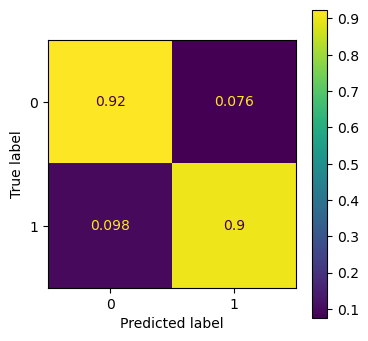

In [20]:
data_modeling.cnf_mat(baseline_model, val_ds)

According to the confusion matrix, the model accurately identified 92% of negative cases and 90% of positive cases. The baseline inaccurately classified 9.8% of sick patients as healthy and 7.6% of healthy patients as sick. Reducing the 9.8% misclassification rate of sick patients (i.e., improving recall) is my primary objective.

### Initializers
After my simple baseline model I decided to experiment with different initializers to help my model start off from a better position, which can lead to faster convergence and potentially better overall performance.

In [21]:
# Loading models to save time
file_names = ['he_normal', 'lecun_normal']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
he_normal,0.1923,0.2118,0.9508,0.9622
lecun_normal,0.1842,0.2128,0.9696,0.9638


Given the similarity in results, I decided to go with 'he_normal' as it is generally recommended for layers with 'relu' activation. I'll be sure to test this again later. 

### Building Complex Model
I opted to enhance the complexity of my model by increasing the number of layers and nodes, aiming to capture any underlying patterns, despite the potential risk of overfitting.

The process started with adding more nodes and dense layers. I then constructed a Convolutional Neural Network (CNN), incrementally introducing more layers and nodes until achieving a sufficiently complex model where signs of overfitting became evident.

In [22]:
file_names = ['Dense_more_nodes','Dense_3_layers','Conv_1_layer','Conv_2_layers','Conv_3_layers']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
Dense_more_nodes,0.1186,0.2243,0.9766,0.9690
Dense_3_layers,0.1021,0.1829,0.9602,0.9727
Conv_1_layer,0.0000,0.2505,0.9766,0.9735
Conv_2_layers,0.0000,0.3926,0.9696,0.9661
Conv_3_layers,0.0000,0.3567,0.9813,0.9703


,Train Loss,Val Loss,Val Recall,Val AUC
Conv_3_layers,0.0,0.3567,0.9813,0.9703


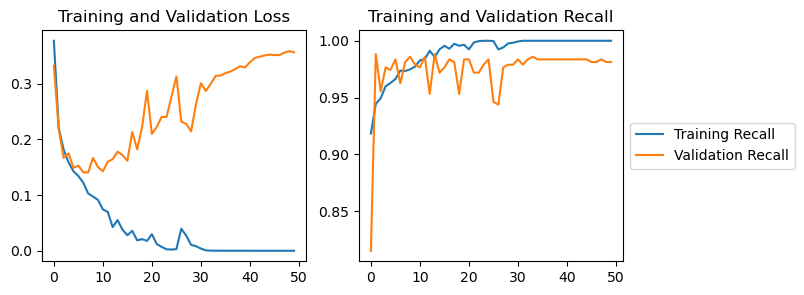

In [23]:
overfit_model = Sequential([
    Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', input_shape= input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu',kernel_initializer='he_normal'),
    Dense(1, activation='sigmoid')
])

overfit_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# results = overfit_model.fit(train_ds, epochs=20, validation_data=val_ds)
overfit_model = data_modeling.summary_viz('Conv_3_layers', train_ds, val_ds)

19/19 [==============================] - 1s 33ms/step


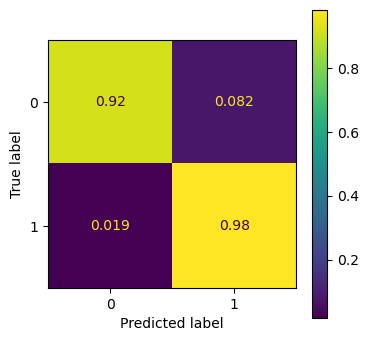

In [24]:
data_modeling.cnf_mat(overfit_model, val_ds)

The overfit model inaccurately classified 1.9% of sick patients as healthy, a significant improvement from the baseline of 9.8%.

### Optimizers
After adding complexity to my model, I started exploring different optimizers to assess their impact on the model's learning efficiency and speed. At this stage, I implemented early stopping to halt training when no significant improvement in validation loss is observed.

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', # metric to monitor for improvment. 
                               min_delta=0.001, # minimum improvement.
                               patience=10, # how long it will wait to see improvment
                               mode='min', 
                               restore_best_weights=True, # after 10 epochs without improvement, it will restore the model with the best weights. 
                               verbose=1)

In [26]:
file_names = ['Adam','SGD','RMSprop','SGD_0.1','SGD_0.01','SGD_0.001','SGD_0.01_momentum_0.5','SGD_0.01_momentum_0.9','SGD_0.01_momentum_0.99']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
Adam,0.0295,0.1231,0.9766,0.9851
SGD,0.0899,0.1226,0.9719,0.9840
RMSprop,0.0645,0.1328,0.9719,0.9833
SGD_0.1,0.0866,0.1229,0.9696,0.9857
SGD_0.01,0.0746,0.1237,0.9602,0.9884
SGD_0.001,0.1463,0.1411,0.9789,0.9831
SGD_0.01_momentum_0.5,0.0986,0.1305,0.9696,0.9853
SGD_0.01_momentum_0.9,0.0732,0.1131,0.9578,0.9879
SGD_0.01_momentum_0.99,0.2212,0.2365,0.9251,0.9596


After testing the Adam, RMSprop, and SGD optimizers with their default learning rates, I chose the SGD optimizer and found optimal values for learning rate and momentum which yielded the quickest convergence and the lowest validation loss

,Train Loss,Val Loss,Val Recall,Val AUC
SGD_0.01_momentum_0.9,0.0732,0.1131,0.9578,0.9879


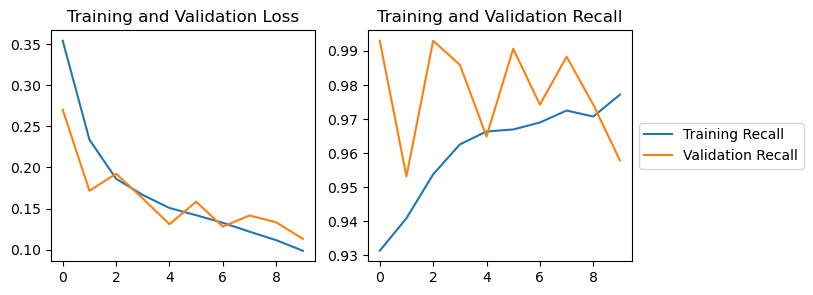

In [27]:
optimized_model = data_modeling.summary_viz('SGD_0.01_momentum_0.9', train_ds, val_ds, early_stopping=True)

### Regularization
Since I have a model that is overfitting, I applied regularization methods, such as dropout, L1/L2 regularization, and data augmentation, help in making the model less sensitive to the specific details of the training data, encouraging it to learn more generalized patterns that apply to unseen data as well.

#### Dropout Layers

In [28]:
file_names = ['After_MaxPooling','After_Conv','After_Dense','After_Max_and_Dense','After_Conv_and_Dense','After_Conv_and_Dense_0.5']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
After_MaxPooling,0.0459,0.1122,0.9578,0.9915
After_Conv,0.0705,0.1062,0.9883,0.9911
After_Dense,0.0693,0.1132,0.9836,0.9858
After_Max_and_Dense,0.0524,0.1113,0.9719,0.9910
After_Conv_and_Dense,0.0373,0.0901,0.9836,0.9933
After_Conv_and_Dense_0.5,0.1513,0.1422,0.9766,0.9893


After experimenting with the placement of dropout layers and adjusting their rates, I determined the optimal configuration for my model involves dropout layers after the Conv2D layers and one before the output layer, with a dropout rate of 0.25. This arrangement effectively prevents overfitting by introducing regularization right after feature extraction in the convolutional layers and prior to the final classification, enhancing the model's ability to generalize from the training data.

,Train Loss,Val Loss,Val Recall,Val AUC
After_Conv_and_Dense,0.0373,0.0901,0.9836,0.9933


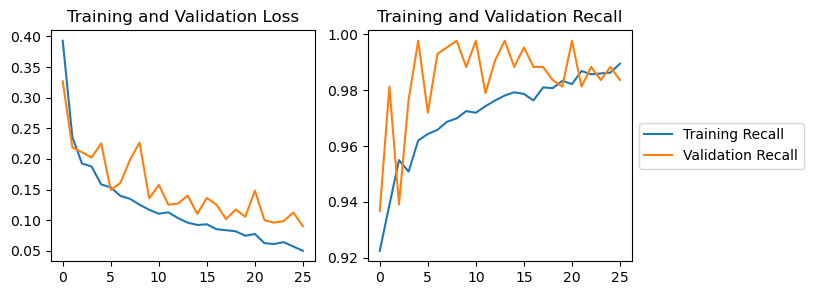

In [29]:
# Dropout layers after Conv2D and Dense layers
dropout_model = Sequential([
    Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', input_shape= input_shape),
    Dropout(0.25),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal'),
    Dropout(0.25),    
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal'),
    Dropout(0.25),    
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu',kernel_initializer='he_normal'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

dropout_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), 
                      loss='binary_crossentropy', 
                      metrics=METRICS)

# loading model instead of running.
# dropout_results = dropout_model.fit(train_ds, epochs=50, validation_data=val_ds, 
#                                     early_stopping= early_stopping)

dropout_model = data_modeling.summary_viz('After_Conv_and_Dense', train_ds, val_ds, early_stopping=True)

19/19 [==============================] - 1s 34ms/step


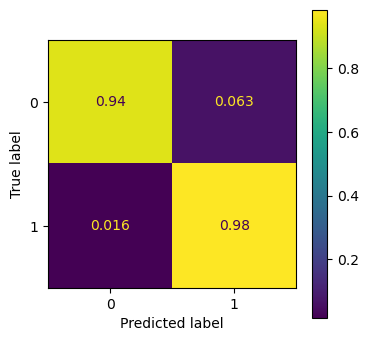

In [30]:
data_modeling.cnf_mat(dropout_model, val_ds)

This model inaccurately classified 1.6% of sick patients as healthy, a small improvement over the overfit model. This model also improved the ability to clasify healthy patients from 92% to 94%.

#### L1/L2 Regularization

In [31]:
file_names = ['L1_Regularization','L2_Regularization']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
L1_Regularization,1.7342,1.7340,1.0000,0.5000
L2_Regularization,0.2279,0.2134,0.9696,0.9827


L2 clearly outperformed L1 regularization.

#### Data Augmentation

In [32]:
file_names = ['Random_Flip','Random_Rotation','Random_Zoom','Combination']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
Random_Flip,0.0837,0.1087,0.9813,0.9885
Random_Rotation,0.1115,0.1107,0.9836,0.9908
Random_Zoom,0.1122,0.1173,0.9578,0.9888
Combination,0.1454,0.1172,0.9813,0.9888


The best data augmentation seemed to be RandomRotation, with a slightly better AUC & Recall. It also converged faster than RandomFlip.

#### Combinations

In [33]:
file_names = ['Drop_L2_Rotation','Drop_L2','Drop_Rotation','L2_Rotation']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
Drop_L2_Rotation,0.3608,0.3387,0.9883,0.9743
Drop_L2,0.1932,0.1904,0.9930,0.9859
Drop_Rotation,0.1633,0.1315,0.9625,0.9886
L2_Rotation,0.2418,0.2033,0.9461,0.9830


Attemping combinations of the most effective regularization methods to see if we can find any improvement. 

Ultimately, I chose the Dropout "After Conv & Dense" model shown above as the best regularization method based on metrics observed.

### Final Adjustments
Once I found a more stable model, I decided to revisit both initializers and optimizers again, just to see if we could improve our results.

In [34]:
file_names = ['Drop_with_Adam', 'Drop_with_RMSprop', 'Drop_without_Initializer', 'Drop_with_Lecun']
data_modeling.summary_df(file_names, train_ds, val_ds)

,Train Loss,Val Loss,Val Recall,Val AUC
Drop_with_Adam,0.0654,0.1072,0.9625,0.9924
Drop_with_RMSprop,0.0928,0.1285,0.9859,0.9875
Drop_without_Initializer,0.0598,0.1033,0.9859,0.9896
Drop_with_Lecun,0.0575,0.1016,0.9836,0.9907


While close, no model showed significant improvement over the Dropout model. 

### Transfer Learning with Resnet
Before finalizing my model selection, I explored transfer learning using the pretrained ResNet50 model.

In [35]:
# Load the ResNet50 model with pretrained weights, but without the top layer
base_model = ResNet50(weights='imagenet', include_top= False, input_shape= resnet_input_shape)

resnet_model = Sequential([base_model,
                                  Flatten(),
                                  Dense(128, activation='relu'),
                                  Dropout(0.25),
                                  Dense(1, activation='sigmoid')])
base_model.trainable = False # Freezing the resnet layer

In [36]:
# Ensuring the resnet layer is frozen.
for layer in resnet_model.layers:
    print(layer.name, layer.trainable)

resnet50 False
flatten_3 True
dense_6 True
dropout_4 True
dense_7 True


,Train Loss,Val Loss,Val Recall,Val AUC
resnet_model,0.3089,0.2962,0.9719,0.9627


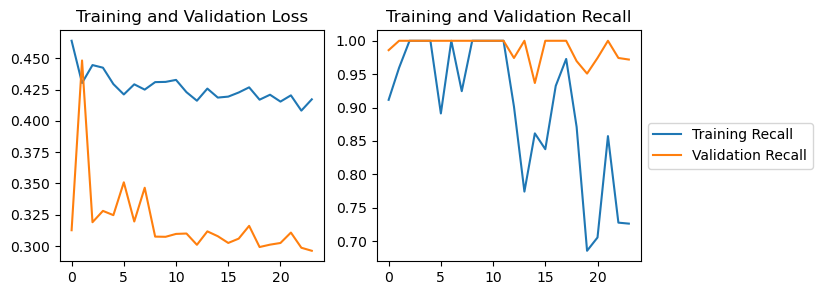

In [37]:
resnet_model.compile(optimizer=SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=METRICS)

# loading model instead of running.
# resnet_results = resnet_model.fit(train_ds_resnet, epochs=50, validation_data=val_ds, verbose=1,
#                     callbacks=early_stopping)

resnet_model = data_modeling.summary_viz('resnet_model', train_ds_resnet, val_ds_resnet, early_stopping=True)

19/19 [==============================] - 7s 296ms/step


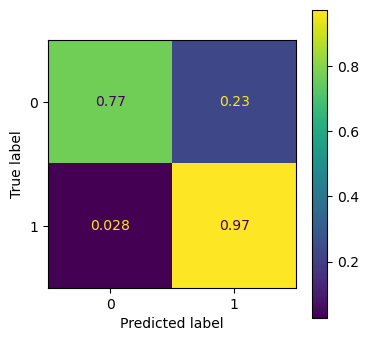

In [38]:
data_modeling.cnf_mat(resnet_model, val_ds_resnet)

While this model's performance on pneumonia images is similar to that of the Dropout model, it significantly underperforms by misclassifying 23% of healthy patients as sick.

### Final model
In the end, the Dropout model performed the best. 

In [39]:
dropout_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 85, 32)        320       
                                                                 
 dropout_14 (Dropout)        (None, 62, 85, 32)        0         
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 31, 42, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 40, 64)        18496     
                                                                 
 dropout_15 (Dropout)        (None, 29, 40, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 14, 20, 64)        0         
 ng2D)                                                

## Evaluation
***

In [40]:
# Loading the test set
test_dir = "data/chest_xray/new_test"
test_ds = create_dataset(test_dir, ratio=AVG_RATIO, process=True, is_training=False)

# Loading the test set for Resnet model
test_ds_grayscale = create_dataset(test_dir)
test_ds_rgb = test_ds_grayscale.map(data_prep.convert_to_rgb)
test_ds_resnet = process_dataset(test_ds_rgb)

Found 588 files belonging to 2 classes.
Found 588 files belonging to 2 classes.


In [41]:
# Dictionary mapping model names to their corresponding model and test dataset
models_dict = {
    'Baseline Model': [baseline_model, test_ds],
    'Overfit Model': [overfit_model, test_ds],
    'Resnet Model': [resnet_model, test_ds_resnet],
    'Final Model': [dropout_model, test_ds]
}

# Initialize an empty list to hold evaluation scores for each model
scores_list = []

# Iterate through the models dictionary to evaluate each model
# and collect their  scores
for model_name, (model, test_dataset) in models_dict.items():
    scores = evaluation.evaluate_model(model, test_dataset)
    scores_list.append(scores)

# Create a DataFrame to summarize the scores for each model
summary_df = pd.DataFrame(scores_list, 
                          columns=['Test Loss', 'Test Recall', 'Test AUC'],
                          index=models_dict.keys())

# Display the summary DataFrame
display(summary_df)

,Test Loss,Test Recall,Test AUC
Baseline Model,0.2912,0.8392,0.9450
Overfit Model,0.3307,0.9580,0.9666
Resnet Model,0.3285,0.9301,0.9329
Final Model,0.1087,0.9720,0.9911


19/19 [==============================] - 1s 32ms/step


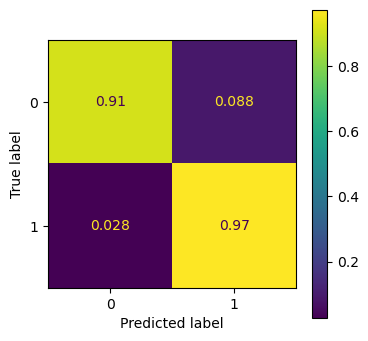

In [42]:
data_modeling.cnf_mat(dropout_model, test_ds)

The final model demonstrated exceptional performance on the unseen test dataset, achieving a recall of 97.2% and an AUC of 99.11%. These results indicate a high ability to correctly identify pneumonia cases, with the model correctly identifying 97.2% of all pneumonia images. The strong performance across validation and testing datasets suggests that the model is likely to generalize well to new, unseen data

### Model Interpretation
We apply the LIME (Local Interpretable Model-Agnostic Explanations) technique to illuminate which regions of the images are influencing the model's predictions. 

Green sections identify areas of the image that support the model's predicton. While red sections idenitfy areas in the image that argue against the model's prediction.

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

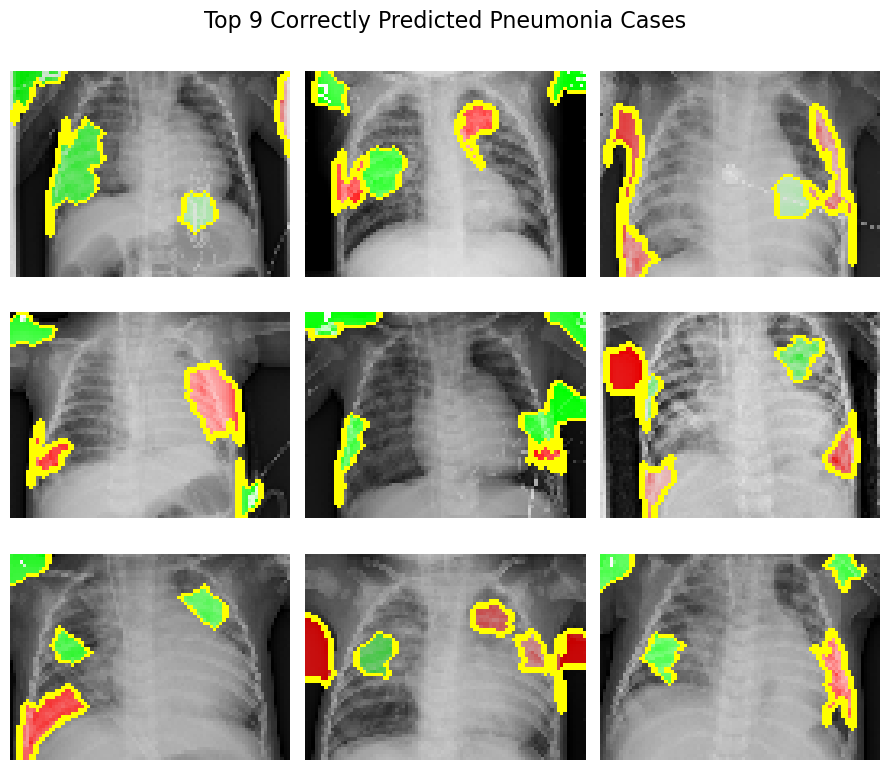

In [43]:
# LIME visualization of the top 9 correctly predicted Pneumonia cases
evaluation.LIME_viz(dropout_model, test_ds, type='TP')

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

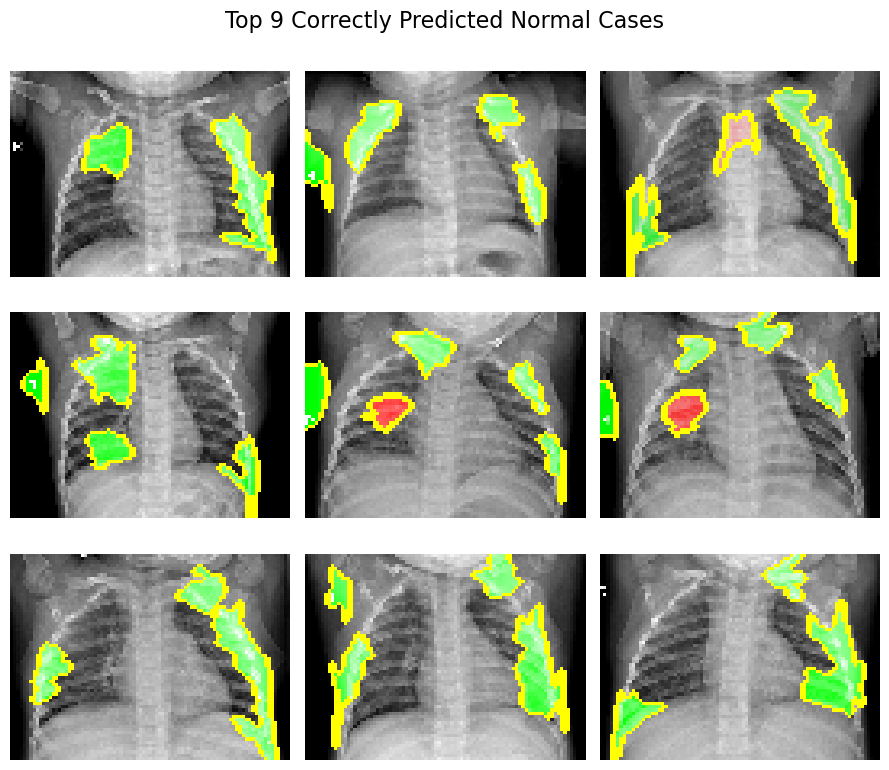

In [44]:
# LIME visualization of the top 9 correctly predicted Normal cases
evaluation.LIME_viz(dropout_model, test_ds, type='TN')

The model seems much more confident in it's True Negative cases given the significantly less red parts on the images.

## Conclusions
***
### Recommendations
Based on the final model, it is recommended that the children's hospital consider incorporating this model into their pneumonia diagnosis workflow. 

Radiologists can use the LIME images to ascertain whether the model is indeed focusing on the appropriate areas of the chest x-rays for its diagnoses, building trust in the model's decision-making process.

Over time, as confidence in the model's diagnostic capabilities grows, the hospital could gradually shift more responsibility to the model. This approach aims to not only enhance diagnostic efficiency but also improve accuracy, ultimately benefiting patient care.

### Limitations
- Although a 97% accuracy rate is impressive, it implies that 3% of patients with the condition are misdiagnosed as healthy.
- Given that the images in this dataset underwent initial quality control, removing low-quality and unreadable scans, the model is likely most effective with high-quality images.
  
### Next Steps
- Encourage increased use of chest X-ray imaging, as the cost to diagnose images has decreased.
- Continuously update the training sets with new images to refine and improve model accuracy.
- Instead of a binary classifier, future models could be made to detect bacterial vs viral pneumonia cases.